In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import IsolationForest
import math
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np # linear algebra
import pandas as pd 
pd.options.mode.chained_assignment = None
import datetime as DT
import io
import requests


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
ucla_state=pd.read_csv("/content/drive/MyDrive/MDA-2022-Italy/Report/Dataset_preparation/historical_state_counts.csv")
df1=ucla_state[['Date', 'State', 'Residents.Confirmed', 'Staff.Confirmed']]
df1.head(100)

,Date,State,Residents.Confirmed,Staff.Confirmed
0,2020-03-22,Alabama,0.0,1.0
1,2020-03-29,Alabama,0.0,2.0
2,2020-04-05,Alabama,0.0,2.0
3,2020-04-12,Alabama,3.0,6.0
4,2020-04-19,Alabama,4.0,9.0
...,...,...,...,...
95,2022-01-16,Alabama,2762.0,1671.0
96,2022-01-23,Alabama,2922.0,1767.0
97,2022-01-30,Alabama,2985.0,1807.0
98,2022-02-06,Alabama,3028.0,1826.0


In [4]:
us_counties=pd.read_csv("/content/drive/MyDrive/MDA-2022-Italy/Report/Dataset_preparation/us-counties.csv")
df2=us_counties[['date', 'state', 'cases', 'county']]
df2.head()

,date,state,cases,county
0,2020-01-21,Washington,1,Snohomish
1,2020-01-22,Washington,1,Snohomish
2,2020-01-23,Washington,1,Snohomish
3,2020-01-24,Illinois,1,Cook
4,2020-01-24,Washington,1,Snohomish


In [5]:
#Pipeline function with parameters (not working well)
'''
state='Alabama'
def stateFilter(dataset, state):
   return  dataset[dataset.iloc[:,1]==state]
stateFilter(ucla_state, state)
transformer1 = FunctionTransformer(stateFilter, kw_args={'state':'Alabama'})

def timeTranform(dateset):
  dateset.iloc[:,0] = pd.to_datetime(dateset.iloc[:,0],format='%Y-%m-%d')
  return  dateset
transformer2 = FunctionTransformer(timeTranform)
timeTranform(ucla_state)

def timeFilter(dataset, start, end):
  filter = (dataset.iloc[:,0] > start) & (dataset.iloc[:,0]  <= end )
  return dataset.loc[filter]
transformer3 = FunctionTransformer(timeTranform, kw_args={'start':'2020-04-01', 'end':'2021-03-31'})
#timeFilter(ucla_state, '2020-04-01','2021-03-31' ).head()
'''

"\nstate='Alabama'\ndef stateFilter(dataset, state):\n   return  dataset[dataset.iloc[:,1]==state]\nstateFilter(ucla_state, state)\ntransformer1 = FunctionTransformer(stateFilter, kw_args={'state':'Alabama'})\n\ndef timeTranform(dateset):\n  dateset.iloc[:,0] = pd.to_datetime(dateset.iloc[:,0],format='%Y-%m-%d')\n  return  dateset\ntransformer2 = FunctionTransformer(timeTranform)\ntimeTranform(ucla_state)\n\ndef timeFilter(dataset, start, end):\n  filter = (dataset.iloc[:,0] > start) & (dataset.iloc[:,0]  <= end )\n  return dataset.loc[filter]\ntransformer3 = FunctionTransformer(timeTranform, kw_args={'start':'2020-04-01', 'end':'2021-03-31'})\n#timeFilter(ucla_state, '2020-04-01','2021-03-31' ).head()\n"

In [6]:
#Pipeline functions

def stateFilter(dataset):
   return  dataset[dataset.iloc[:,1]=='Washington']
#stateFilter(ucla_state)
transformer1 = FunctionTransformer(stateFilter)

def timeTranform(dateset):
  dateset.iloc[:,0] = pd.to_datetime(dateset.iloc[:,0],format='%Y-%m-%d')
  return  dateset
transformer2 = FunctionTransformer(timeTranform)
#timeTranform(ucla_state)

def timeFilter(dataset):
  filter = (dataset.iloc[:,0] > '2020-04-01') & (dataset.iloc[:,0]  <= '2021-03-31' )
  return dataset.loc[filter]
transformer3 = FunctionTransformer(timeFilter)
#timeFilter(ucla_state).head()

def resetIndex(dataset):
  dataset = dataset.reset_index(drop=True)
  return dataset
transformer4 = FunctionTransformer(resetIndex)
#timeFilter(ucla_state).head()


In [7]:
#Pipeline
pipeline=Pipeline([
        ("State", transformer1),
        ('Format', transformer2),
        ('Period', transformer3),
        ('ResetIndex', transformer4)
    ])

df1 = pipeline.fit_transform(df1)
df2 = pipeline.fit_transform(df2)
df2.head(1000)

,date,state,cases,county
0,2020-04-02,Washington,20,Adams
1,2020-04-02,Washington,133,Benton
2,2020-04-02,Washington,19,Chelan
3,2020-04-02,Washington,8,Clallam
4,2020-04-02,Washington,131,Clark
...,...,...,...,...
995,2020-04-28,Washington,17,Asotin
996,2020-04-28,Washington,415,Benton
997,2020-04-28,Washington,100,Chelan
998,2020-04-28,Washington,17,Clallam


In [8]:
# Taking gradient of the cumulative cases for prisons
firstValue=df1['Residents.Confirmed'].iloc[0]
firstValue2= df1['Staff.Confirmed'].iloc[0]
df1['Residents.Confirmed']=df1['Residents.Confirmed'].diff()
df1['Residents.Confirmed'].iloc[0]=firstValue
df1['Staff.Confirmed']=df1['Staff.Confirmed'].diff()
df1['Staff.Confirmed'].iloc[0]=firstValue2

In [9]:
df1.head()

,Date,State,Residents.Confirmed,Staff.Confirmed
0,2020-04-05,Washington,7.0,14.0
1,2020-04-12,Washington,4.0,0.0
2,2020-04-19,Washington,2.0,10.0
3,2020-04-26,Washington,5.0,8.0
4,2020-05-03,Washington,6.0,3.0


In [ ]:
# Summing up deaths and cases yearly based on  state variable 
#grouped_df = us_counties.groupby(['state',pd.Grouper(key='date',freq='M')])['deaths','cases'].sum().reset_index().sort_values('date')
df2_grouped = df2.groupby(['state',pd.Grouper(key='date',freq='W-MON')])['cases'].sum().reset_index().sort_values('date')
df2_grouped = df2_grouped.rename(columns={'state':'State', 'date':'Date', 'cases':'State.Confirmed'})
df2=df2_grouped[:-1]
df2.head()

,State,Date,State.Confirmed
0,Washington,2020-04-06,37422
1,Washington,2020-04-13,68466
2,Washington,2020-04-20,80145
3,Washington,2020-04-27,92461
4,Washington,2020-05-04,105976


In [ ]:
# Taking gradient of the cumulative cases for prisons
firstValue=df2['State.Confirmed'].iloc[0]
df2['State.Confirmed']=df2['State.Confirmed'].diff()
df2['State.Confirmed'].iloc[0]=firstValue
df2.head()

,State,Date,State.Confirmed
0,Washington,2020-04-06,37422.0
1,Washington,2020-04-13,31044.0
2,Washington,2020-04-20,11679.0
3,Washington,2020-04-27,12316.0
4,Washington,2020-05-04,13515.0


In [ ]:
df1['State.Confirmed'] = df2['State.Confirmed']
df1.head(1000)


,Date,State,Residents.Confirmed,Staff.Confirmed,State.Confirmed
0,2020-04-05,Washington,7.0,14.0,37422.0
1,2020-04-12,Washington,4.0,0.0,31044.0
2,2020-04-19,Washington,2.0,10.0,11679.0
3,2020-04-26,Washington,5.0,8.0,12316.0
4,2020-05-03,Washington,6.0,3.0,13515.0
5,2020-05-10,Washington,2.0,5.0,15377.0
6,2020-05-17,Washington,8.0,2.0,12119.0
7,2020-05-24,Washington,7.0,1.0,10426.0
8,2020-05-31,Washington,22.0,6.0,12637.0
9,2020-06-07,Washington,31.0,20.0,14818.0


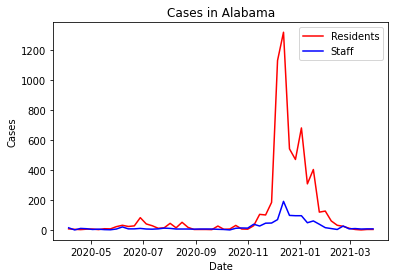

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

#Spaghetti Plot (not working well-maybe normalization?)

fig1= df1[['Residents.Confirmed','Date']].groupby('Date').mean()
  
fig2=df1[['Staff.Confirmed','Date']].groupby('Date').mean()

fig3=df1[['State.Confirmed','Date']].groupby('Date').mean()


plt.plot(fig1, color='r', label='Residents')
plt.plot(fig2, color='b', label='Staff')
#plt.plot(fig3, color='g', label='Community')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("Cases in Alabama")
plt.legend()
plt.show()



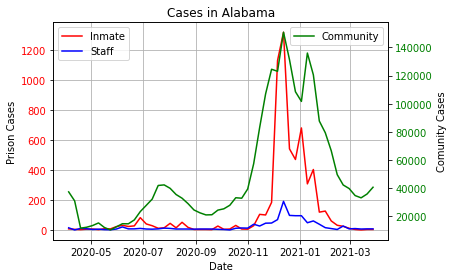

In [ ]:
fig1= df1[['Residents.Confirmed','Date']].groupby('Date').mean()
fig2=df1[['Staff.Confirmed','Date']].groupby('Date').mean()
fig3=df1[['State.Confirmed','Date']].groupby('Date').mean()


fig, ax = plt.subplots()
ax.plot(fig1, color='red', label='Inmate')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(fig3, color='green', label='Community')
ax2.tick_params(axis='y', labelcolor='green')

ax.plot(fig2, color='b', label='Staff')
# Naming the x-axis, y-axis and the whole graph
plt.title("Cases in Alabama")
ax.grid()
ax.set_xlabel("Date")
ax.set_ylabel("Prison Cases")
ax2.set_ylabel("Comunity Cases")
plt.legend()
ax.legend(loc=2)
plt.show()

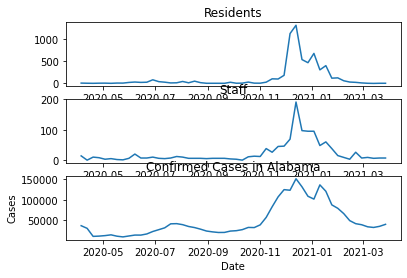

In [ ]:
figure, axis = plt.subplots(3, 1)
fig1= df1[['Residents.Confirmed','Date']].groupby('Date').mean()
axis[0].plot(fig1)
axis[0].set_title("Residents")
  
fig2=df1[['Staff.Confirmed','Date']].groupby('Date').mean()
axis[1].plot(fig2)
axis[1].set_title("Staff")
  
fig3=df1[['State.Confirmed','Date']].groupby('Date').mean()
axis[2].plot(fig3)
axis[2].set_title("Community")

plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("Confirmed Cases in Alabama")

plt.show()

In [ ]:
fig = px.line(df1.reset_index(), x='Date', y='Residents.Confirmed', title='Inmate New Cases')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [ ]:
import plotly.express as px
fig2 = px.line(df1.reset_index(), x='Date', y='Staff.Confirmed', title='Staff New Cases')
fig2.update_xaxes(
    rangeslider_visible=True,
)
fig2.show()

In [ ]:
import plotly.express as px
fig3 = px.line(df1.reset_index(), x='Date', y='State.Confirmed', title='State New Cases')
fig3.update_xaxes(
    rangeslider_visible=True,
)
fig3.show()

# Anomaly Detection

In [ ]:
from sklearn.ensemble import IsolationForest
model =  IsolationForest(contamination=0.03)
model.fit(df1[['Residents.Confirmed']])
df1['outliers']=pd.Series(model.predict(df1[['Residents.Confirmed']])).apply(lambda x: 'yes' if (x == -1) else 'no' )
df1.query('outliers=="yes"')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



,Date,State,Residents.Confirmed,Staff.Confirmed,State.Confirmed,outliers
35,2020-12-06,Washington,1133.0,69.0,123007.0,yes
36,2020-12-13,Washington,1322.0,191.0,150717.0,yes


In [ ]:
fig = px.scatter(df1.reset_index(), x='Date', y='Residents.Confirmed', color='outliers', hover_data=['Date'], title='Inmate New Cases')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [ ]:
from sklearn.ensemble import IsolationForest
model =  IsolationForest(contamination=0.004)
model.fit(df1[['Staff.Confirmed']])
df1['outliers']=pd.Series(model.predict(df1[['Staff.Confirmed']])).apply(lambda x: 'yes' if (x == -1) else 'no' )
df1.query('outliers=="yes"')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



,Date,State,Residents.Confirmed,Staff.Confirmed,State.Confirmed,outliers
36,2020-12-13,Washington,1322.0,191.0,150717.0,yes


In [ ]:
fig = px.scatter(df1.reset_index(), x='Date', y='Staff.Confirmed', color='outliers', hover_data=['Date'], title='Staff New Cases')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [ ]:
from sklearn.ensemble import IsolationForest
model =  IsolationForest(contamination=0.01)
model.fit(df1[['State.Confirmed']])
df1['outliers']=pd.Series(model.predict(df1[['State.Confirmed']])).apply(lambda x: 'yes' if (x == -1) else 'no' )
df1.query('outliers=="yes"')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



,Date,State,Residents.Confirmed,Staff.Confirmed,State.Confirmed,outliers
36,2020-12-13,Washington,1322.0,191.0,150717.0,yes


In [ ]:
fig = px.scatter(df1.reset_index(), x='Date', y='State.Confirmed', color='outliers', hover_data=['Date'], title='State New Cases')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

# Prediction


In [ ]:
import matplotlib.dates as mdates
import plotly.graph_objs as go
import plotly.express as px
from datetime import date, timedelta
from sklearn.cluster import KMeans
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
df1.set_index(['Date'], inplace = True) 
df1.index=pd.to_datetime(df1.index)

In [ ]:
df1=df1.drop(columns=['State','outliers'],axis=1)
x=np.arange(len(df1)).reshape(-1,1)
y=df1.values
y

array([[7.00000e+00, 1.40000e+01, 3.74220e+04],
       [4.00000e+00, 0.00000e+00, 3.10440e+04],
       [2.00000e+00, 1.00000e+01, 1.16790e+04],
       [5.00000e+00, 8.00000e+00, 1.23160e+04],
       [6.00000e+00, 3.00000e+00, 1.35150e+04],
       [2.00000e+00, 5.00000e+00, 1.53770e+04],
       [8.00000e+00, 2.00000e+00, 1.21190e+04],
       [7.00000e+00, 1.00000e+00, 1.04260e+04],
       [2.20000e+01, 6.00000e+00, 1.26370e+04],
       [3.10000e+01, 2.00000e+01, 1.48180e+04],
       [2.30000e+01, 7.00000e+00, 1.47630e+04],
       [2.70000e+01, 7.00000e+00, 1.75170e+04],
       [8.20000e+01, 1.00000e+01, 2.34400e+04],
       [4.00000e+01, 6.00000e+00, 2.78480e+04],
       [2.80000e+01, 5.00000e+00, 3.23070e+04],
       [1.10000e+01, 7.00000e+00, 4.19660e+04],
       [1.40000e+01, 1.20000e+01, 4.23780e+04],
       [4.40000e+01, 1.00000e+01, 3.99450e+04],
       [1.40000e+01, 6.00000e+00, 3.55500e+04],
       [5.10000e+01, 6.00000e+00, 3.29370e+04],
       [1.70000e+01, 6.00000e+00, 2.9083

In [ ]:
data1=pd.DataFrame(df1)
data1

,Residents.Confirmed,Staff.Confirmed,State.Confirmed
Date,,,
2020-04-05,7.0,14.0,37422.0
2020-04-12,4.0,0.0,31044.0
2020-04-19,2.0,10.0,11679.0
2020-04-26,5.0,8.0,12316.0
2020-05-03,6.0,3.0,13515.0
2020-05-10,2.0,5.0,15377.0
2020-05-17,8.0,2.0,12119.0
2020-05-24,7.0,1.0,10426.0
2020-05-31,22.0,6.0,12637.0


In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
_=model.fit(x, y)

In [ ]:
test = np.arange(12).reshape(-1, 1)
pred = model.predict(test)
prediction = pred.round().astype(int)
prediction

array([[   28,     7, 12129],
       [   32,     8, 13565],
       [   35,     8, 15002],
       [   39,     9, 16438],
       [   43,    10, 17875],
       [   46,    11, 19311],
       [   50,    11, 20747],
       [   54,    12, 22184],
       [   57,    13, 23620],
       [   61,    13, 25056],
       [   65,    14, 26493],
       [   68,    15, 27929]])

In [ ]:
week = [df1.index[51] + timedelta(weeks=i) for i in range(1,len(prediction)+1)]
dt_idx = pd.DatetimeIndex(week)
predicted_count = pd.DataFrame(prediction, dt_idx, columns=['Residents.Confirmed', 'Staff.Confirmed', 'State.Confirmed'])
predicted_count

,Residents.Confirmed,Staff.Confirmed,State.Confirmed
2021-04-04,28,7,12129
2021-04-11,32,8,13565
2021-04-18,35,8,15002
2021-04-25,39,9,16438
2021-05-02,43,10,17875
2021-05-09,46,11,19311
2021-05-16,50,11,20747
2021-05-23,54,12,22184
2021-05-30,57,13,23620
2021-06-06,61,13,25056


In [ ]:
predicted_df=pd.concat([df1,predicted_count])
predicted_df.index.name= 'Date'
predicted_df


,Residents.Confirmed,Staff.Confirmed,State.Confirmed
Date,,,
2020-04-05,7.0,14.0,37422.0
2020-04-12,4.0,0.0,31044.0
2020-04-19,2.0,10.0,11679.0
2020-04-26,5.0,8.0,12316.0
2020-05-03,6.0,3.0,13515.0
...,...,...,...
2021-05-23,54.0,12.0,22184.0
2021-05-30,57.0,13.0,23620.0
2021-06-06,61.0,13.0,25056.0


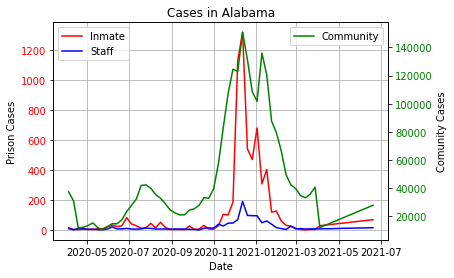

In [ ]:

pd.plotting.register_matplotlib_converters()

fig1=predicted_df[['Residents.Confirmed']].groupby('Date').mean()
fig2=predicted_df[['Staff.Confirmed']].groupby('Date').mean()
fig3=predicted_df[['State.Confirmed']].groupby('Date').mean()


fig, ax = plt.subplots()
ax.plot(fig1, color='red', label='Inmate')
ax.tick_params(axis='y', labelcolor='red')

ax2 = ax.twinx()
ax2.plot(fig3, color='green', label='Community')
ax2.tick_params(axis='y', labelcolor='green')

ax.plot(fig2, color='b', label='Staff')
# Naming the x-axis, y-axis and the whole graph
plt.title("Cases in Alabama")
ax.grid()
ax.set_xlabel("Date")
ax.set_ylabel("Prison Cases")
ax2.set_ylabel("Comunity Cases")
plt.legend()
ax.legend(loc=2)
plt.show()

In [ ]:
fig = px.scatter(predicted_df.reset_index(), x='Date', y='Residents.Confirmed', hover_data=['Date'], title='Inmate New Cases')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()